In [29]:
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3
from keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.models import Sequential
import numpy as np
from glob import glob

In [30]:
# re-size all the images to this
IMAGE_SIZE = [90,90]

train_path = 'G:/Breast_Cancer_dataset'
#valid_path = 'Datasets/test'


In [31]:
# Import the Vgg 16 library as shown below and add preprocessing layer to the front of VGG
# Here we will be using imagenet weights

#inception = InceptionV3(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)
vgg=VGG16(input_shape=IMAGE_SIZE + [3],weights='imagenet',include_top=False)



In [32]:
# don't train existing weights
for layer in vgg.layers:
    layer.trainable = False

In [33]:
  # useful for getting number of output classes
#import glob2
folders =glob('G:/Breast_Cancer_dataset/*')

In [34]:
# our layers - you can add more if you want
x = Flatten()(vgg.output)

In [35]:
prediction = Dense(len(folders), activation='softmax')(x)

# create a model object
model = Model(inputs=vgg.input, outputs=prediction)

In [36]:
#model.summary()

In [37]:
# tell the model what cost and optimization method to use
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)


In [38]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

In [39]:
# Make sure you provide the same target size as initialied for the image size
training_set = train_datagen.flow_from_directory('G:/Breast_cancer_dataset',
                                                 target_size = (90,90),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

Found 1578 images belonging to 2 classes.


In [42]:
# fit the model
# Run the cell. It will take some time to execute
r = model.fit_generator(
  training_set,
  epochs=5,
  steps_per_epoch=len(training_set)
)
model.save('breast_cancer-model')

Epoch 1/5
50/50 [==============================] - 115s 2s/step - loss: 0.1583 - accuracy: 0.9360
Epoch 2/5
50/50 [==============================] - 115s 2s/step - loss: 0.1562 - accuracy: 0.9328
Epoch 3/5
50/50 [==============================] - 115s 2s/step - loss: 0.1498 - accuracy: 0.9335
Epoch 4/5
50/50 [==============================] - 124s 2s/step - loss: 0.1498 - accuracy: 0.9366
Epoch 5/5
50/50 [==============================] - 116s 2s/step - loss: 0.1415 - accuracy: 0.9423
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: breast_cancer-model\assets


normal


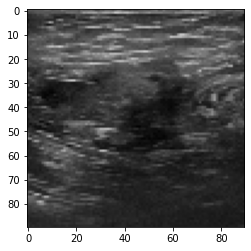

In [53]:
from keras.models import load_model
import matplotlib.pyplot as plt
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
import numpy as np
CATEGORIES=['Cancer','normal']
model=load_model("breast_cancer-model")
img=image.load_img('G:/TRAINING_EXAMPLE/normal_1.png',target_size=(90,90))
plt.imshow(img)
x=image.img_to_array(img)
x=np.expand_dims(x,axis=0)
img_data=preprocess_input(x)
classes=model.predict(img_data)
print(CATEGORIES[int(classes[0][0])])